Outliers removed: 798
Calculated deceleration capacity: 0.7892520696545802


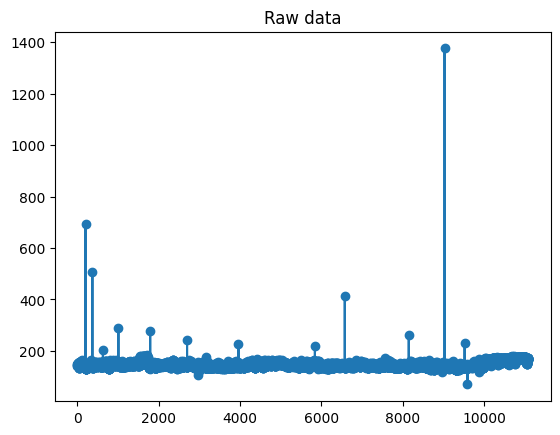

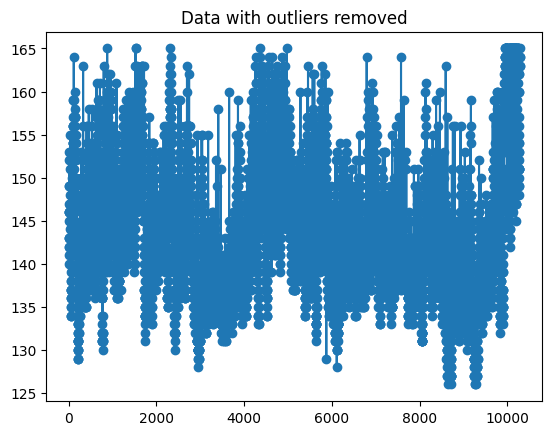

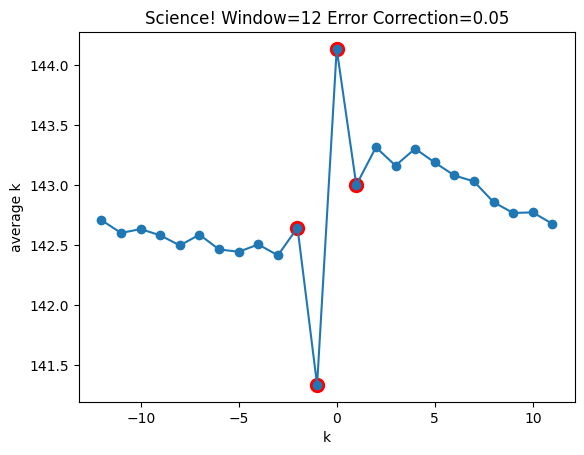

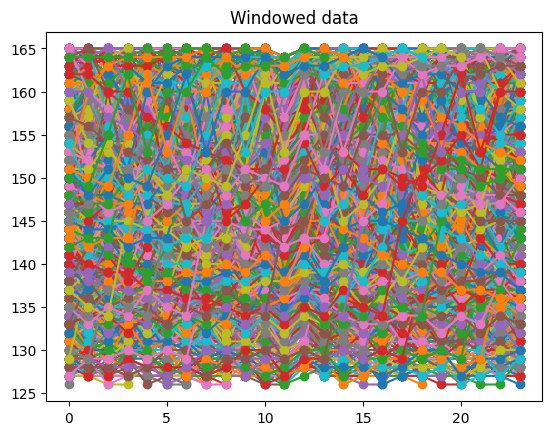

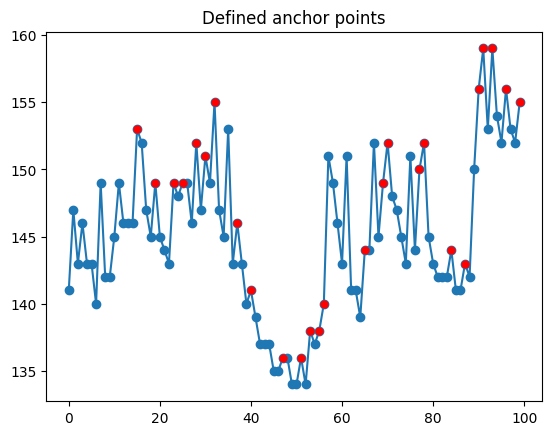

In [25]:

import argparse
import matplotlib.pyplot as plt
import pandas as pd
import csv
import numpy as np

# reads any numerical values in the first column of the excel file
def read_first_column_excel(excel_path):
    # Replace 'your_file.xlsx' with the path to your Excel file
    column_name = 'RR-I(ms):ECG'

    # Read the Excel file
    df = pd.read_excel(excel_path)

    # Select the column
    column_data = df[column_name]
    if column_data.empty:
        print('Column with name {} not found'.format(column_name))
        return
    
    numerical_data = column_data.apply(pd.to_numeric, errors='coerce')
    numerical_data = numerical_data.dropna()

    return numerical_data

# reads any numerical values in the first column of the CSV file
def read_first_column_csv(csv_path):
    # Initialize an empty list to store the first column data
    first_column_data = []

    # Open the CSV file
    with open(csv_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)

        # Loop through each row in the CSV file
        for row in reader:
            # Add the first column of each row to the list if the row is not empty and it's a number
            if row and row[0]:
                try:
                    value = float(row[0])
                    first_column_data.append(value)
                except ValueError:
                    pass

    return first_column_data


# filters in rr_data that is num_standard_deviations away from the mean
# also removes data for values that are not within a reasonable range
def remove_outliers(data, num_standard_deviations):
    data = [x for x in data if (x < 300 and x > 80)]
    mean = np.mean(data)
    std = np.std(data)
    data = [x for x in data if (x > mean - num_standard_deviations * std) and (x < mean + num_standard_deviations * std)]
    return data

# find the anchor points by checking if x+1 is greater than x, and the percentage change is less than the error correction
def find_anchor_points(data, window, error_correction):
    anchor_points = []
    for index, _ in enumerate(data[window:], start=window):
        x = data[index-1]
        x_plus_1 = data[index]
        if x_plus_1 > x:
            percentage_change = abs(x_plus_1 - x) / x_plus_1 * 100
            if (percentage_change < error_correction*100):
                anchor_points.append(index)

    return anchor_points


# take the anchor points and creates a window but getting the points to the left and right of the anchor point
def create_windowed_data(data, anchor_points, window):
    windowed_data = []
    for anchor_point in anchor_points:
        windowed_data.append(data[anchor_point-window:anchor_point+window])
    return windowed_data


# finds X(0), X(1), etc..
def calculate_average_windows(windowed_data):
    summed_window = [0]*len(windowed_data[0])  # initialize a list of 0's
    averaged_window = [0]*len(windowed_data[0])  # initialize a list of 0's

    for window in windowed_data:
        for index, value in enumerate(window):
            summed_window[index] = summed_window[index] + float(value)

    for index, value in enumerate(summed_window):
        averaged_window[index] = value / len(windowed_data)

    return averaged_window


def calculate_average_deceleration_capacity(data, window):
    dc = (data[window] + data[window+1] - data[window-1] - data[window-2])/4
    return dc

def parse_args():
    return
    # # Create the parser
    # parser = argparse.ArgumentParser(description='Example of parsing command line options.')

    # # Add an argument
    # # The 'dest' parameter specifies the name of the attribute to be added to the object returned by parse_args().
    # parser.add_argument('-n', '--name', dest='name', type=str, help='Your name')

    # # Optional argument with default value
    # parser.add_argument('-a', '--age', dest='age', type=int, default=25, help='Your age')

    # # Boolean flag
    # parser.add_argument('--happy', action='store_true', help='Are you happy?')

    # # Parse the command line arguments
    # args = parser.parse_args()

    # # Access the arguments
    # print(f"Name: {args.name}")
    # print(f"Age: {args.age}")
    # print(f"Happy: {'Yes' if args.happy else 'No'}")


def main():
    excel_path = '21-11 CVS rat 29 Test 2.1.xlsx'
    window_size = 12
    error_correction=0.05

    # read the data from the excel file
    rr_data_unfiltered = read_first_column_excel(excel_path)
    # remove any outliers from the read data
    rr_data = remove_outliers(rr_data_unfiltered, num_standard_deviations=2)
    # find the anchor points in the data set
    anchor_points = find_anchor_points(rr_data, window_size, error_correction)
    # Create a window of data for each anchor points of size window_size
    windowed_data = create_windowed_data(rr_data, anchor_points, window_size)
    # Calculate a single window of data from all the windowed data
    averaged_window = calculate_average_windows(windowed_data)
    # Use the averaged window to calculate deceleration capacity
    deceleration_capacity = calculate_average_deceleration_capacity(
        averaged_window, window_size)

    print('Outliers removed: {}'.format(
        len(rr_data_unfiltered) - len(rr_data)))

    print('Calculated deceleration capacity: {}'.format(deceleration_capacity))

    plt.plot(rr_data_unfiltered, marker='o')
    plt.title('Raw data')
    plt.show()    

    plt.plot(rr_data, marker='o')
    plt.title('Data with outliers removed')
    plt.show()    

    highlight_x = []
    highlight_y = []
    highlight_x.append(0)
    highlight_y.append(averaged_window[window_size])
    highlight_x.append(1)
    highlight_y.append(averaged_window[window_size+1])
    highlight_x.append(-1)
    highlight_y.append(averaged_window[window_size-1])
    highlight_x.append(-2)
    highlight_y.append(averaged_window[window_size-2])
    plt.plot(highlight_x, highlight_y, linestyle='', marker='o', color='red', markersize=10, label='Highlighted points')

    x_values = range(-window_size, window_size)
    plt.plot(x_values, averaged_window, marker='o')
    plt.xlabel('k')  # Optional: Label for the x-axis
    plt.ylabel('average k')  # Optional: Label for the y-axis
    plt.title('Science! Window={} Error Correction={}'.format(window_size, error_correction))
    plt.show()

    for data in windowed_data:
        plt.plot(data, marker='o')

    plt.title('Windowed data')
    plt.show()

    # mark the points we found as anchor points for validation. This is a sanity check.
    data_range = 100
    rr_subset = rr_data[0:data_range]
    highlight_x = []
    highlight_y = []
    for point in anchor_points:
        if point < data_range:
            highlight_x.append(point)
            highlight_y.append(rr_subset[point])

    plt.plot(rr_subset, marker='o')
    plt.plot(highlight_x, highlight_y, linestyle='', marker='o',
             color='red', markersize=5, label='Highlighted points')
    plt.title('Defined anchor points')
    plt.show()


if __name__ == "__main__":
    main()
